In [136]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier

In [137]:
x_train = pd.read_csv('x_train_openSmile_emobase.csv')
y_train = pd.read_csv('y_train_openSmile_emobase.csv')
x_test = pd.read_csv('x_test_openSmile_emobase.csv')
y_test = pd.read_csv('y_test_openSmile_emobase.csv')

y_test['emotion'] = np.where(y_test['emotion'] == 'happy', 1, 0)
y_train['emotion'] = np.where(y_train['emotion'] == 'happy', 1, 0)

In [162]:
etc = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

etc.fit(x_train, y_train["emotion"])

importances = etc.feature_importances_

sorted_importances = np.sort(importances)[::-1]
cumulative_importances = np.cumsum(sorted_importances)
threshold_index = np.searchsorted(cumulative_importances, 0.6) # 55 6 9
threshold_value = sorted_importances[threshold_index]

selector_model = SelectFromModel(etc, threshold=threshold_value, prefit=True)

selected_features = x_train.columns[selector_model.get_support()]


=== SVC Classification Report ===
              precision    recall  f1-score   support

   not happy       0.94      0.92      0.93       530
       happy       0.63      0.70      0.66       107

    accuracy                           0.88       637
   macro avg       0.78      0.81      0.80       637
weighted avg       0.89      0.88      0.88       637

=== SVC Confusion Matrix ===


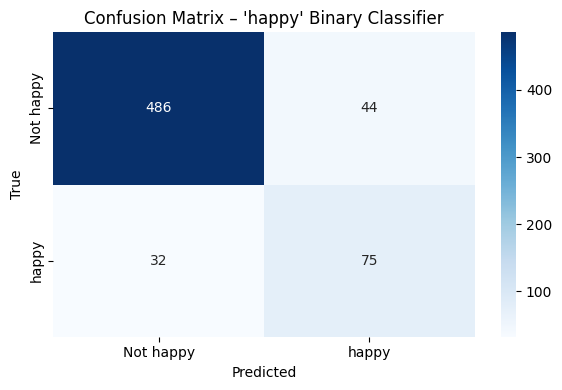

In [163]:

selector = ColumnTransformer(
  [
    ("pick_happy", "passthrough", selected_features)
  ],
  remainder="drop"
)
weights = {0: 0.6, 1: 40}
svc = SVC(
  kernel="rbf",
  class_weight="balanced",
  probability=True,
  random_state=42
)

happy_pipeline = Pipeline([
  ("select", selector),
  ("svc", svc)
])

happy_pipeline.fit(x_train, y_train['emotion'])
y_pred_svc = happy_pipeline.predict(x_test)

print("=== SVC Classification Report ===")
print(classification_report(y_test, y_pred_svc, target_names=["not happy","happy"]))

print("=== SVC Confusion Matrix ===")
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_svc, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"happy"}", "happy"],
    yticklabels=[f"Not {"happy"}", "happy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"happy"}' Binary Classifier")
plt.tight_layout()
plt.show()

In [165]:
joblib.dump(happy_pipeline, "happy_svc_model.pkl")

['happy_svc_model.pkl']